<a href="https://colab.research.google.com/github/AHamamd150/MLscan_group/blob/main/AL_Varitional_Autoencoder_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Learning with Varitional autoencoder.
*  The idea is to use the VAE ontop of Active learning to remove the collapsed pointns around the boundries. VAE latent space is sampled as $\mu + exp^{(0.5 \sigma)}$. with $\mu,\sigma$ are the mean and the standard deviation  values of the feature space. Once the VAE is trained we freeze the encoder and use the mean value of the latent space of the decoder to generate points spreaded around the boundries. The mean value of the latent space is perturpated as $\mu\times (1-\epsilon)$.

# Pros:
* The structure of the VAE model is independent of the input-output dimensions.
* Only one parameter is used to spread the generated points around the boundries

# Cons:
* It is time consuming.
* $\epsilon$ is hyperparameter and has to be optimized in each scan

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
# from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model,Sequential,layers
from tensorflow.keras.layers import Flatten,Dense,Dropout
import os
import keras
from keras.losses import mse,CategoricalCrossentropy,binary_crossentropy
from keras import backend as K
from tqdm import tqdm
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier,RandomForestClassifier
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
import sys
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
## check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found.....')
    #sys.exit()
else:
    print('Default GPU device :{}'.format(tf.test.gpu_device_name()))
    
################

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: No GPU found.....


In [2]:
def obs(x1,x2):
    F = (2+np.cos(x1/3)*np.cos(x2/5))**5
    #F = (3*x1)**2+x2**2+7
    return np.array(F)  
def generate_init(n):
    x1,x2=[],[]
    for q in range(n):
        x1.append(np.random.uniform(0,10*np.pi))
        x2.append(np.random.uniform(0,10*np.pi))
    return np.array(x1),np.array(x2),np.array([x1,x2]).T

def orcal(x1,x2):
    F = (2+np.cos(x1/3)*np.cos(x2/5))**5
    #F = (3*x1)**2+x2**2+7 +    
    for q,item in enumerate(F):
      if (item > 80 and item < 120 ):
        F[q] = 1
      else:
        F[q] =0   
    return np.array(F)  

score = lambda x : np.array([q*(1-q) for q in x])

In [3]:

def sampling(args):

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon=0.0
    return z_mean + K.exp(z_log_var)*epsilon

def encoder():
    encoder1 = Dense(100,activation='relu') (encoder_input)
    #encoder2 = Dense(70,activation='relu') (encoder1)
    encoder3 = Dense(50,activation='relu') (encoder1)
   # encoder4 = Dense(20,activation='relu') (encoder3)
    encoder5 = Dense(10,activation='relu') (encoder3)
    z_mean = layers.Dense(latent, name='z_mean')(encoder5)
    z_log_var = layers.Dense(latent, name='z_log_var')(encoder5)
    z = layers.Lambda(sampling, output_shape=(latent,), name='z')([z_mean, z_log_var])
    encoder_model = Model(encoder_input, [z_mean, z_log_var, z])
    return encoder_model, z_mean, z_log_var



# define the decoder
def decoder():
    decoder_input = keras.Input(shape=(latent,))
    decoder1 = Dense(10,activation='relu') (decoder_input)
    #decoder2 = Dense(20,activation='relu') (decoder1)
    decoder3 = Dense(50,activation='relu') (decoder1)
    #decoder4 = Dense(70,activation='relu') (decoder3)
    decoder5 = Dense(100,activation='relu') (decoder3)
    decoder_output = layers.Dense(2,activation=None)(decoder5)
    decoder_model= Model(decoder_input,decoder_output)
    return decoder_model


latent=2  # Dimensions of the latent space
decoder_inputdim=10 
encoder_input = keras.Input(shape=(2,)) 

encoder_model, z_mean, z_log_var = encoder() 
decoder_model = decoder() 
encoder_model.summary(),decoder_model.summary();    
outputs = decoder_model(encoder_model(encoder_input)[2]) # 2 to return the z parameter
VAE = Model(encoder_input,outputs,name='VAE') 
# define the custom loss function as : reconstruction loss function + KL divergence loss function
def Loss(inputs,output):
    inputs = K.flatten(inputs)
    output= K.flatten(outputs)
    reconstruction_loss = mse(inputs, output)
    reconstruction_loss *= decoder_inputdim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    VAE_loss =K.mean(reconstruction_loss + kl_loss)
    return VAE_loss

VAE.add_loss(Loss(encoder_input,outputs))
VAE.compile(optimizer='adam',loss=None)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          300         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 50)           5050        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 10)           510         ['dense_1[0][0]']                
                                                                                              

In [37]:
def run_AL(runs =20,learning_rate=0.01,n_estimators=100,max_depth=30,print_output=True,ep=0.1):
    BDT =GradientBoostingClassifier(learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth)
    x1,x2,X=generate_init(1000)
    obs1 = orcal(x1, x2)
    BDT.fit(X, obs1)         
    badP1,badP2 =[],[]
    for q in tqdm(range(runs),ascii=True,desc='Progress'): 
      X1,X24,x = generate_init(5000)
      pred = BDT.predict(x).flatten()
      X_new = x[pred==1][:90]
      q = np.argsort(score(pred))[::-1]
      q_new = x#[q[:10]]
      X_new = np.append(X_new,q_new[:10],axis=0)
      VAE.fit(X_new,epochs=500,verbose=0)
      z_mean, _, _ = encoder_model.predict(X_new)
      z_mean1 = np.array(z_mean)*(1- np.random.uniform(-ep,ep))
      x_new= decoder_model.predict(z_mean1)
      #x_new = X_new
      ob = orcal(x_new[:,0], x_new[:,1])
      Y = ob == 1
      badP1.append(x_new[ob!=1][:,0])  
      badP2.append(x_new[ob!=1][:,1])
      X= np.append(X,x_new[Y],axis=0)
      obs1=np.append(obs1,ob[Y],axis=0)
      BDT.fit(X, obs1) 
    return X,badP1,badP2


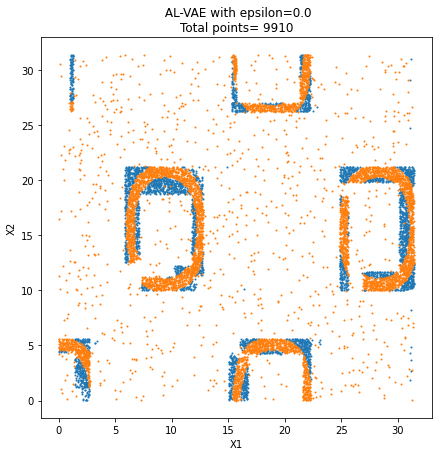

In [41]:
Flatten = lambda x : [item for i in x for item in i]    
#XL,dd1,dd2 = run_AL(runs=99,ep=0.0)
plt.figure(figsize=(7,7))
plt.scatter(Flatten(dd1),Flatten(dd2),s=1,label = 'bad points')
plt.scatter(XL[:,0],XL[:,1],s=1,label='good points');

plt.xlabel('X1')
plt.ylabel('X2')
#plt.legend(fontsize=15)
plt.title(''' AL-VAE with epsilon=0.0
Total points= {}'''.format(len(XL[:,0])+len(Flatten(dd1))));
#plt.xlim(0,10*np.pi);
#plt.ylim(0,10*np.pi);


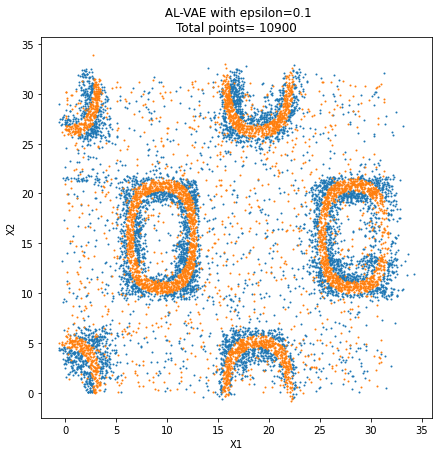

In [31]:
Flatten = lambda x : [item for i in x for item in i]    
XL,dd1,dd2 = run_AL(runs=99,ep=0.1)
plt.figure(figsize=(7,7))
plt.scatter(Flatten(dd1),Flatten(dd2),s=1,label = 'bad points')
plt.scatter(XL[:,0],XL[:,1],s=1,label='good points');

plt.xlabel('X1')
plt.ylabel('X2')
#plt.legend(fontsize=15)
plt.title(''' AL-VAE with epsilon=0.1
Total points= {}'''.format(len(XL[:,0])+len(Flatten(dd1))));
#plt.xlim(0,10*np.pi);
#plt.ylim(0,10*np.pi);


Progress: 100%|##########| 99/99 [10:20<00:00,  6.27s/it]


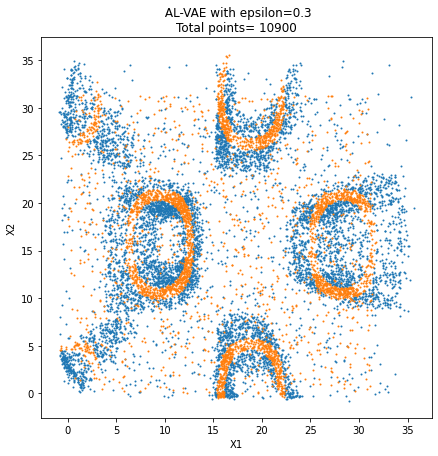

In [35]:
Flatten = lambda x : [item for i in x for item in i]    
XL,dd1,dd2 = run_AL(runs=99,ep=0.3)
plt.figure(figsize=(7,7))
plt.scatter(Flatten(dd1),Flatten(dd2),s=1,label = 'bad points')
plt.scatter(XL[:,0],XL[:,1],s=1,label='good points');

plt.xlabel('X1')
plt.ylabel('X2')
#plt.legend(fontsize=15)
plt.title(''' AL-VAE with epsilon=0.3
Total points= {}'''.format(len(XL[:,0])+len(Flatten(dd1))));
#plt.xlim(0,10*np.pi);
#plt.ylim(0,10*np.pi);


Progress: 100%|##########| 99/99 [09:36<00:00,  5.82s/it]


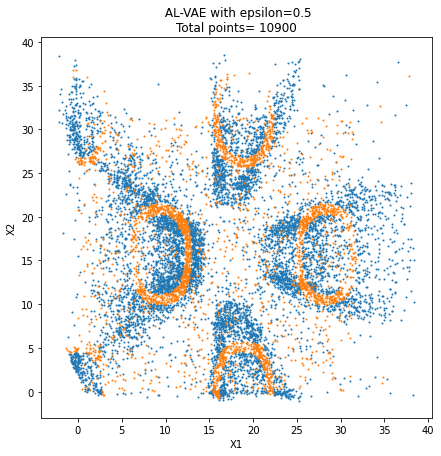

In [36]:
Flatten = lambda x : [item for i in x for item in i]    
XL,dd1,dd2 = run_AL(runs=99,ep=0.5)
plt.figure(figsize=(7,7))
plt.scatter(Flatten(dd1),Flatten(dd2),s=1,label = 'bad points')
plt.scatter(XL[:,0],XL[:,1],s=1,label='good points');

plt.xlabel('X1')
plt.ylabel('X2')
#plt.legend(fontsize=15)
plt.title(''' AL-VAE with epsilon=0.5
Total points= {}'''.format(len(XL[:,0])+len(Flatten(dd1))));
#plt.xlim(0,10*np.pi);
#plt.ylim(0,10*np.pi);
